## Bingham Rotation Learning Demo
Demo requires `lrcurve`: `pip install lrcurve`.

In [1]:
import torch
import numpy as np
from networks import *
from losses import *
from helpers_sim import *
import argparse

Create a parser object with our desired settings:

In [2]:
parser = argparse.ArgumentParser(description='Synthetic Wahba arguments.')
parser.add_argument('--sim_sigma', type=float, default=1e-2)
parser.add_argument('--N_train', type=int, default=500)
parser.add_argument('--N_test', type=int, default=100000)
parser.add_argument('--matches_per_sample', type=int, default=25)

parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--batch_size_train', type=int, default=50)
parser.add_argument('--batch_size_test', type=int, default=100)
parser.add_argument('--lr', type=float, default=5e-4)

parser.add_argument('--dataset', choices=['static', 'dynamic', 'dynamic_beachball'], default='static')
parser.add_argument('--beachball_sigma_factors', type=lambda s: [float(item) for item in s.split(',')], default=[0.1, 0.5, 2, 10], help='Heteroscedastic point cloud that has different noise levels (resembling a beachball).')
parser.add_argument('--max_rotation_angle', type=float, default=180., help='In degrees. Maximum axis-angle rotation of simulated rotation.')

parser.add_argument('--cuda', action='store_true', default=False)
parser.add_argument('--double', action='store_true', default=False)
parser.add_argument('--enforce_psd', action='store_true', default=False)
parser.add_argument('--unit_frob', action='store_true', default=False)

args = parser.parse_args([])
print(args)

Namespace(N_test=100000, N_train=500, batch_size_test=100, batch_size_train=50, beachball_sigma_factors=[0.1, 0.5, 2, 10], cuda=False, dataset='static', double=False, enforce_psd=False, epochs=50, lr=0.0005, matches_per_sample=25, max_rotation_angle=180.0, sim_sigma=0.01, unit_frob=False)


Specify the device to use while training

In [3]:
device = torch.device('cuda:0') if args.cuda else torch.device('cpu')
tensor_type = torch.double if args.double else torch.float

Generate the training and test data

In [4]:
def gen_sim_data_new(N_rotations, N_matches_per_rotation, sigma, max_rotation_angle=None, dtype=torch.double):
    ##Simulation
    #Create a random rotation
    axis = torch.randn(N_rotations, 3, dtype=dtype)
    axis = axis / axis.norm(dim=1, keepdim=True)
    if max_rotation_angle:
        max_angle = max_rotation_angle*np.pi/180.
    else:
        max_angle = np.pi
    
    angle = max_angle*torch.rand(N_rotations, 1)

    C = SO3_torch.exp(angle*axis).as_matrix()
    if N_rotations == 1:
        C = C.unsqueeze(dim=0)
    #Create two sets of vectors (normalized to unit l2 norm)
    #x_1 = torch.randn(N_rotations, 3, N_matches_per_rotation, dtype=dtype)#just change this to N_rotations/10
    x_1 = torch.randn(int(1), 3, N_matches_per_rotation, dtype=dtype)
    x_1 = x_1/x_1.norm(dim=1,keepdim=True)
    x_1 = x_1.repeat(int(N_rotations), 1, 1) #This still needs to be N_rotations dimensions 
    
    #Rotate and add noise
    noise = sigma*torch.randn_like(x_1)
    x_2 = C.bmm(x_1) + noise
    
    return C, x_1, x_2

In [5]:
def create_experimental_data_new(N_train=2000, N_test=50, N_matches_per_sample=100, sigma=0.01, beachball=False, max_rotation_angle=None, beachball_factors=None, device=torch.device('cpu'), dtype=torch.double):
    
    if beachball:
        C_train, x_1_train, x_2_train = gen_sim_data_beachball(N_train, N_matches_per_sample, sigma, beachball_factors)
        C_test, x_1_test, x_2_test = gen_sim_data_beachball(N_test, N_matches_per_sample, sigma, beachball_factors)
    else:
        C_train, x_1_train, x_2_train = gen_sim_data_new(N_train, N_matches_per_sample, sigma, max_rotation_angle=max_rotation_angle)
        C_test, x_1_test, x_2_test = gen_sim_data_new(N_test, N_matches_per_sample, sigma, max_rotation_angle=max_rotation_angle)

    x_train = torch.empty(N_train, 2, N_matches_per_sample, 3, dtype=dtype, device=device)
    x_train[:,0,:,:] = x_1_train.transpose(1,2)
    x_train[:,1,:,:] = x_2_train.transpose(1,2)
    
    q_train = rotmat_to_quat(C_train, ordering='xyzw').to(dtype=dtype, device=device)
    if q_train.dim() < 2:
        q_train = q_train.unsqueeze(dim=0)


    x_test = torch.empty(N_test, 2, N_matches_per_sample, 3, dtype=dtype, device=device)
    x_test[:,0,:,:] = x_1_test.transpose(1,2)
    x_test[:,1,:,:] = x_2_test.transpose(1,2)
    
    q_test = rotmat_to_quat(C_test, ordering='xyzw').to(dtype=dtype, device=device)
    if q_test.dim() < 2:
        q_test = q_test.unsqueeze(dim=0)
    
    train_data = SyntheticData(x_train, q_train, None)
    test_data = SyntheticData(x_test, q_test, None)
    
    return train_data, test_data   

In [6]:
train_data, test_data = create_experimental_data_new(args.N_train, args.N_test, args.matches_per_sample,
                                                          sigma=args.sim_sigma, device=device, dtype=tensor_type)

# Adjugate from q learn with plots
In this notebook we are going to do something very similar to notebook 13, but just a little cleaner and with the plot to compare to the notebook 1 results.

### Original Learning Model

In [7]:
#Input: 10 numbers that defines a symmetric 4x4 matrix
#Output: unit 4-vector defining unit-quaternion
def A_vec_to_quat(A_vec):
    A = convert_Avec_to_A(A_vec)
    _, evs = torch.symeig(A, eigenvectors=True)
    return evs[:,:,0].squeeze()

#Basic example
class BinghamNetDemo(torch.nn.Module):
    def __init__(self):
        super(BinghamNetDemo, self).__init__()
        self.A_net = PointNet(dim_out=10, normalize_output=False, batchnorm=False)

    def output_A(self, x):
        A_vec = self.A_net(x)
        return convert_Avec_to_A(A_vec)

    def forward(self, x):
        A_vec = self.A_net(x)
        q = A_vec_to_quat(A_vec)
        return q

Set up the cost function and model for our approach and the 2 baselines

In [8]:
model_quat = PointNet(dim_out=4, normalize_output=True).to(device=device, dtype=tensor_type)
loss_fn_quat = quat_chordal_squared_loss

model_6D = RotMat6DDirect().to(device=device, dtype=tensor_type)
loss_fn_6D = rotmat_frob_squared_norm_loss

#model_bingham = QuatNet(enforce_psd=args.enforce_psd, unit_frob_norm=args.unit_frob).to(device=device, dtype=tensor_type)
model_bingham = BinghamNetDemo()
loss_fn_bingham = quat_chordal_squared_loss

Train the models on the same data

In [9]:
models = [model_quat, model_6D, model_bingham]
losses = [loss_fn_quat, loss_fn_6D, loss_fn_bingham]
rotmat_targets = [False, True, False]
result = train_test_models_with_plots(args, train_data, test_data, models, losses, rotmat_targets=rotmat_targets)

In [10]:
q_est = result[2]

In [11]:
len(test_data.q)

100000

In [12]:
len(q_est)

100

In [13]:
#need to concatenate somethings
len(result)

3000

In [14]:
q_est_list = result[2000:3000]

In [15]:
len(q_est_list)

1000

In [16]:
type(q_est_list)

list

In [17]:
q_est = [item for sublist in q_est_list for item in sublist]

In [18]:
len(q_est)

100000

In [19]:
q_est_Tensor = torch.Tensor([item.tolist() for sublist in q_est_list for item in sublist])

In [20]:
len(q_est_Tensor)

100000

### Let's see if we can do better

Their result for one set of data points.

In [21]:
#ESTIMATED
q_est[0]

tensor([-0.0386,  0.0427, -0.1641,  0.9848])

In [22]:
#REAL
test_data.q[0]

tensor([-0.0427,  0.0411, -0.1387,  0.9886])

In [23]:
#DATA
test_data.x[0]

tensor([[[ 0.5087,  0.4175,  0.7529],
         [ 0.7071, -0.7062,  0.0358],
         [-0.9603, -0.1613,  0.2276],
         [ 0.8413,  0.3865, -0.3778],
         [ 0.8230,  0.5293, -0.2062],
         [ 0.0440, -0.2998,  0.9530],
         [-0.7870, -0.5088, -0.3490],
         [ 0.8048,  0.4497, -0.3873],
         [ 0.4004, -0.8866,  0.2316],
         [-0.4802,  0.8168,  0.3197],
         [ 0.8101,  0.4450, -0.3818],
         [ 0.7953,  0.1132, -0.5955],
         [ 0.0575, -0.0509,  0.9970],
         [ 0.2797, -0.8018, -0.5281],
         [-0.6127, -0.7363, -0.2873],
         [ 0.2129,  0.4915, -0.8445],
         [-0.5603, -0.7182, -0.4126],
         [-0.8828,  0.3884, -0.2640],
         [-0.5316, -0.7962,  0.2890],
         [-0.3831, -0.0655, -0.9214],
         [ 0.3741, -0.6323, -0.6784],
         [-0.9512,  0.3042,  0.0512],
         [-0.8939, -0.4295,  0.1285],
         [-0.0801,  0.5696,  0.8180],
         [ 0.3824, -0.0794, -0.9206]],

        [[ 0.6604,  0.3082,  0.6630],
         [

Now lets see what just doing RMSD gives us for this set of points.

First we need to define: $E = X \cdot Y^T$

which should be a 3 x 3 matrix.

In [24]:
#Lets set
X = test_data.x[0][0]
Y = test_data.x[0][1]

In [25]:
Y_T = np.transpose(Y)

In [26]:
Y_T

tensor([[ 0.6604,  0.5021, -0.9498,  0.9020,  0.9168,  0.0416, -0.9263,  0.8605,
          0.1754, -0.2025,  0.8642,  0.7465,  0.1310,  0.0161, -0.8088,  0.2578,
         -0.7678, -0.7745, -0.7017, -0.4841,  0.1249, -0.8368, -0.9414,  0.1509,
          0.2510],
        [ 0.3082, -0.8601,  0.1256,  0.0964,  0.2739, -0.2196, -0.3107,  0.1740,
         -0.9517,  0.9511,  0.1820, -0.1665, -0.0122, -0.8715, -0.5612,  0.3624,
         -0.5721,  0.5956, -0.6056, -0.0262, -0.7537,  0.5617, -0.1386,  0.6438,
         -0.2449],
        [ 0.6630,  0.0530,  0.3161, -0.4806, -0.3038,  0.9640, -0.2550, -0.4702,
          0.2652,  0.2777, -0.4889, -0.6384,  0.9882, -0.4885, -0.1660, -0.9098,
         -0.3053, -0.2340,  0.3997, -0.8750, -0.6320,  0.0812,  0.2349,  0.7637,
         -0.9307]])

In [27]:
E = np.dot(X,Y_T)

In [28]:
E.shape

(25, 25)

This is wrong, let's try the other way around, just because python is not shaping things the way we think.

In [29]:
X_T = np.transpose(X)

In [30]:
E = np.dot(X_T,Y)

In [31]:
E.shape

(3, 3)

To find $R_{opt}$ from $E$ we use the definition

$R_{opt} = V \cdot D \cdot U^T$

which requires that we first perform an SVD to get $V$ and $U$, such that $E = U \cdot S \cdot V^T$.

In [32]:
u, s, vh = np.linalg.svd(E, full_matrices=True)

Then we need to construct $D$ from $V$ and $U$. $D$ is a diagonal matrix where all values are 1 except the last one which is:

$D_{entry} = sign(Det (V \cdot U^T))$

In [33]:
#First we constract the form of the matrix
D = np.identity(3)

In [34]:
#Then we define D_entry
vut = np.dot(np.transpose(vh),np.transpose(u))
D_entry = np.linalg.det(vut)

In [35]:
D_entry

1.0

In [36]:
np.sign(D_entry)

1.0

In [37]:
D[-1,-1]=np.sign(D_entry)

In [38]:
D

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Now we can define $R_{opt}$.

In [39]:
R_opt_int = np.dot(np.transpose(vh),D)

In [40]:
R_opt = np.dot(R_opt_int,np.transpose(u))

In [41]:
R_opt

array([[ 0.95914612,  0.2675478 ,  0.09196136],
       [-0.27429912,  0.95904026,  0.07072368],
       [-0.06927268, -0.09305931,  0.99324782]])

Now convert this to a quaternion.

In [42]:
from scipy.spatial.transform import Rotation as R

In [43]:
r = R.from_matrix(R_opt)

In [44]:
r.as_quat()

array([-0.04140672,  0.04076231, -0.13698676,  0.9888673 ])

How does this compare to the actual value?

In [45]:
test_data.q[0]

tensor([-0.0427,  0.0411, -0.1387,  0.9886])

Wow that's super close.

### Now I need to figure out how to calculate the error in degrees, and then do that for all 100 test points and plot the mean and std error on the same plot.

First the error.

In [46]:
#THEIR ESTIMATE
quat_angle_diff(q_est[0],test_data.q[0])

tensor(2.9840)

In [47]:
#RMSD
r_quat_tens = torch.Tensor(r.as_quat())
quat_angle_diff(r_quat_tens,test_data.q[0])

tensor(0.2516)

In [ ]:
ours_test_mean_err

Okay, seems about right, I guess.

In [ ]:
#Now to calculate the RMSD for all 100 points and output in the same format as test_data.q

In [48]:
#First make a function and make sure it works for my original data point
def RMSD_function(test_data):
    RMSD_result = []

    for i in range(len(test_data.x)):
        #i=0
        X = test_data.x[i][0]
        Y = test_data.x[i][1]
        X_T = np.transpose(X)
        E = np.dot(X_T,Y)
        u, s, vh = np.linalg.svd(E, full_matrices=True)
        D = np.identity(3)
        vut = np.dot(np.transpose(vh),np.transpose(u))
        D_entry = np.linalg.det(vut)
        D[-1,-1]=np.sign(D_entry)
        R_opt_intermediate = np.dot(np.transpose(vh),D)
        R_opt = np.dot(R_opt_intermediate,np.transpose(u))
        r = R.from_matrix(R_opt)
        RMSD_result.append(r.as_quat())
        
    return RMSD_result

In [49]:
#RMSD_function(test_data) #this was setting i = 0

Good job!

In [50]:
my_result = RMSD_function(test_data)

In [51]:
len(my_result)

100000

In [52]:
my_result_tensor = torch.Tensor(my_result)

In [54]:
test_mean_err

tensor([0.0407])

In [55]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/Users/shanson/opt/anaconda3/envs/STARS/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['outer', 'allclose', 'isclose', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [56]:
#Let's not look at the average error, but instead the histogram of errors for the two methods

In [57]:
#For q_est
num_test_batches = len(q_est)
ours_errors = []
for k in range(num_test_batches):
    ours_errors.append(quat_angle_diff(q_est[k], test_data.q[k]))

In [58]:
num_test_batches = len(my_result_tensor)
errors = []
for k in range(num_test_batches):
    errors.append(quat_angle_diff(my_result_tensor[k], test_data.q[k]))

In [59]:
errors_list = [item.tolist() for item in errors]

In [ ]:
plt.semilogy()
plt.plot(ours_errors,'bo')
plt.axhline(y=ours_test_mean_err,color='b',label='Test error (A)')
plt.axhline(y=test_mean_err,color='k',label='RMSD soln')
plt.plot(errors,'ko')
plt.legend()
plt.ylim(0,50)
plt.ylabel('distance in degrees')
plt.xlabel('index')

Now we have the idea that we can make this plot (semilogy, two above) and also include the 'quat' and '6D' estimates for the test data to make this plot.

In [64]:
quats_NN_list = result[0:1000]

In [65]:
len(quats_NN_list)

1000

In [66]:
quats_NN = [item for sublist in quats_NN_list for item in sublist]

In [67]:
quats_NN_Tensor = torch.Tensor([item.tolist() for sublist in quats_NN_list for item in sublist])

In [68]:
NN_6D_list  = result[1000:2000]

In [69]:
len(NN_6D_list)

1000

In [70]:
NN_6D = [item for sublist in NN_6D_list for item in sublist]

In [71]:
NN_6D_Tensor = torch.Tensor([item.tolist() for sublist in NN_6D_list for item in sublist])

In [72]:
targets = quat_to_rotmat(test_data.q) #note conversion of quat to rotmat


In [73]:
#now to not just get avg error
num_test_batches = len(quats_NN)
quats_errors = []
for k in range(num_test_batches):
    quats_errors.append(quat_angle_diff(quats_NN_Tensor[k], test_data.q[k]))

num_test_batches = len(NN_6D)
errors_6D = []
for k in range(num_test_batches):
    errors_6D.append(rotmat_angle_diff(NN_6D_Tensor[k], targets[k])) #note use of targets and rotmat

In [ ]:
plt.semilogy()

#plt.axhline(y=quats_test_mean_err,color='g',label='quat')
##plt.axhline(y= test_mean_err_6D,color='r',label='6D')
#plt.axhline(y=ours_test_mean_err,color='b',label='A')
#plt.axhline(y=test_mean_err,color='k',label='RMSD soln')

plt.plot(quats_errors,'go')
plt.plot(errors_6D,'ro')
plt.plot(ours_errors,'bo')
plt.plot(errors,'ko')

plt.legend()
plt.ylabel('distance in degrees')
plt.xlabel('index')


In [74]:
#quats
min(quats_errors), max(quats_errors)

(tensor(0.1117), tensor(179.9295))

In [135]:
mean(quats_errors), std(quats_errors)

(9.589912, 17.526608)

In [75]:
#6D
min(errors_6D), max(errors_6D)

(tensor(0.3487), tensor(19.2364))

In [134]:
mean(errors_6D), std(errors_6D)

(7.538205, 2.6217835)

In [76]:
#A
min(ours_errors), max(ours_errors)

(tensor(0.0652), tensor(13.2191))

In [133]:
mean(ours_errors), std(ours_errors)

(4.3235335, 2.1061547)

In [77]:
#RMSD
min(errors), max(errors)

(tensor(0.0051), tensor(0.7244))

In [131]:
mean(errors), std(errors)

(0.22575144, 0.09563155)

No handles with labels found to put in legend.


Text(0.5, 0, 'index')

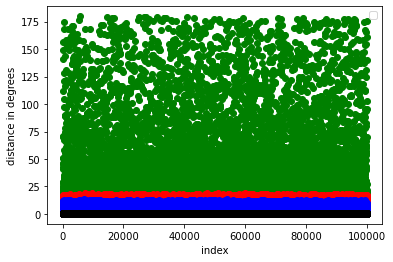

In [78]:
#plt.axhline(y=quats_test_mean_err,color='g',label='quat')
##plt.axhline(y= test_mean_err_6D,color='r',label='6D')
#plt.axhline(y=ours_test_mean_err,color='b',label='A')
#plt.axhline(y=test_mean_err,color='k',label='RMSD soln')

plt.plot(quats_errors,'go')
plt.plot(errors_6D,'ro')
plt.plot(ours_errors,'bo')
plt.plot(errors,'ko')

plt.legend()
plt.ylabel('distance in degrees')
plt.xlabel('index')


# Now for the adjugate learning version.

In [79]:
def construct_adjugate(q):
    adjugate = []
    [qx,qy,qz,q0] = q
    q_ordered = [float(q0),float(qx),float(qy),float(qz)]
    adjugate.append([float(q0)* item for item in q_ordered])
    adjugate.append([float(qx)* item for item in q_ordered])
    adjugate.append([float(qy)* item for item in q_ordered])
    adjugate.append([float(qz)* item for item in q_ordered])
    return adjugate

In [80]:
#save these for later
train_q = train_data.q
test_q = test_data.q

In [81]:
A_train_accumulator = []
for i in range(len(train_data.q)):
    A = construct_adjugate(train_data.q[i])
    A_train_accumulator.append(A)

In [82]:
A_train_tensor = torch.Tensor(A_train_accumulator)

In [83]:
train_data.q = A_train_tensor

In [84]:
A_test_accumulator = []
for i in range(len(test_data.q)):
    A = construct_adjugate(test_data.q[i])
    A_test_accumulator.append(A)

In [85]:
A_test_tensor = torch.Tensor(A_test_accumulator)

In [86]:
test_data.q = A_test_tensor

And we use our slightly edited learning/plotting function.

In [87]:
def train_test_models_with_plots_one(args, train_data, test_data, models, loss_fns, rotmat_targets, verbose=False):
    """
    Helper for rss_demo.ipynb
    :param args:
    :param train_data:
    :param test_data:
    :param models:
    :param loss_fn:
    :param rotmat_targets:
    :param verbose:
    :return:
    """
    # from jupyterplot import ProgressPlot
    from lrcurve.plot_learning_curve import PlotLearningCurve
    # from matplotlib import pyplot as plt
    optimizers = [torch.optim.Adam(model.parameters(), lr=args.lr) for model in models]

    # Save stats for plotting
    train_stats = torch.empty(len(models), args.epochs, 2)
    test_stats = torch.empty(len(models), args.epochs, 2)

    device = torch.device('cuda:0') if args.cuda else torch.device('cpu')
    tensor_type = torch.double if args.double else torch.float

    # JupyterPlot way (broken!)
    # pp_train = ProgressPlot(line_names=["Quaternion", "6D", "Bingham"], x_lim=[0, args.epochs])
    # pp_test = ProgressPlot(line_names=["Quaternion", "6D", "Bingham"], x_lim=[0, args.epochs])
    # pp = ProgressPlot(plot_names=["Train", "Test"], line_names=["Quaternion", "6D", "Bingham"],
    #                   x_lim=[0, args.epochs], y_lim=[-3, 3])
    # lrcurve way
    # plot = PlotLearningCurve()
    plot = PlotLearningCurve(
        facet_config={
            'train': {'name': 'Train Err. (deg)', 'limit': [1e-2, 1e3], 'scale': 'log10'},
            'test': {'name': 'Test Err. (deg)', 'limit': [1e-2, 1e3], 'scale': 'log10'}
        },
        mappings = {
            'train_quat': { 'line': 'train_quat', 'facet': 'train'},
            'test_quat': { 'line': 'test_quat', 'facet': 'test'},
        },
        line_config={
            'train_quat': {'name': 'train', 'color': '#3B76AF'},
            'test_quat': {'name': 'test', 'color': '#3B76AF'},
        },
        xaxis_config={'name': 'Epoch', 'limit': [0, args.epochs]}
    )
    # PyPlot way
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.ion()

    # fig.show()
    # fig.canvas.draw()
    with plot:
        for e in range(args.epochs):
            start_time = time.time()

            if args.dataset is not 'static':
                beachball = (args.dataset == 'dynamic_beachball')
                beachball_factors = args.beachball_sigma_factors
                train_data, test_data = create_experimental_data_fast(args.N_train, args.N_test, args.matches_per_sample,
                                                                    max_rotation_angle=args.max_rotation_angle,
                                                                    sigma=args.sim_sigma, beachball=beachball,
                                                                    beachball_factors=beachball_factors, device=device,
                                                                    dtype=tensor_type)

            num_train_batches = args.N_train // args.batch_size_train
            train_loss = torch.zeros(len(models))
            train_mean_err = torch.zeros(len(models))
            for idx, (model, optimizer, loss_fn, rotmat_target) in enumerate(zip(models, optimizers, loss_fns, rotmat_targets)):
                for k in range(num_train_batches):
                    start, end = k * args.batch_size_train, (k + 1) * args.batch_size_train
                    #print('start:',start)
                    #print('end:',end)
        
                    if rotmat_target:
                        targets = quat_to_rotmat(train_data.q[start:end])
                        (C_est, train_loss_k) = train_minibatch(model, loss_fn, optimizer, train_data.x[start:end], targets)
                        train_mean_err[idx] += (1 / num_train_batches) * rotmat_angle_diff(C_est, targets)
                    else:
                        targets = train_data.q[start:end]
                        (q_est, train_loss_k) = train_minibatch(model, loss_fn, optimizer, train_data.x[start:end], targets)
                        #train_mean_err[idx] += (1 / num_train_batches) * quat_angle_diff(q_est, targets)
        
                    train_loss[idx] += (1 / num_train_batches) * train_loss_k

            # Test model
            if verbose:
                print('Testing...')
            num_test_batches = args.N_test // args.batch_size_test
            test_loss = torch.zeros(len(models))
            test_mean_err = torch.zeros(len(models))
            q_est_collect = []
            for idx, (model, loss_fn, rotmat_target) in enumerate(zip(models, loss_fns, rotmat_targets)):
                for k in range(num_test_batches):
                    start, end = k * args.batch_size_test, (k + 1) * args.batch_size_test
        
                    if rotmat_target:
                        targets = quat_to_rotmat(test_data.q[start:end])
                        (C_est, test_loss_k) = test_model(model, loss_fn, test_data.x[start:end], targets)
                        q_est_collect.append(C_est)
                        test_mean_err[idx] += (1 / num_test_batches) * rotmat_angle_diff(C_est, targets)
                    else:#this is temporarily changed
                        targets = test_data.q[start:end]
                        (q_est, test_loss_k) = test_model(model, loss_fn, test_data.x[start:end], targets)
                        q_est_collect.append(q_est)
                        #test_mean_err[idx] += (1 / num_test_batches) * quat_angle_diff(q_est, targets)
                        #test_mean_err[idx] += (1 / num_test_batches) * (q_est.unsqueeze(dim=0) - targets.unsqueeze(dim=0)).norm(dim=[1])
        
                    test_loss[idx] += (1 / num_test_batches) * test_loss_k

            # History tracking
            train_stats[:, e, 0] = train_loss
            #train_stats[:, e, 1] = train_mean_err
            test_stats[:, e, 0] = test_loss
            #test_stats[:, e, 1] = test_mean_err

        
            plot.append(e, {
                #'train_quat': train_mean_err[0],
                #'test_quat': test_mean_err[0],
                 'train_quat': train_loss[0],
                 'test_quat': test_loss[0],
            })
            plot.draw()

    return q_est_collect

In [88]:
class AdjugateNetDemo(torch.nn.Module):
    def __init__(self):
        super(AdjugateNetDemo, self).__init__()
        self.A_net = PointNet(dim_out=10, normalize_output=False, batchnorm=False)

    def output_A(self, x):
        A_vec = self.A_net(x)
        return convert_Avec_to_A(A_vec)

    def forward(self, x):
        A_vec = self.A_net(x)
        return convert_Avec_to_A(A_vec)

In [89]:
model_adj = AdjugateNetDemo()
loss_fn_frobenius = rotmat_frob_squared_norm_loss

In [90]:
models = [model_adj]
losses = [loss_fn_frobenius]
rotmat_targets = [False] 
result = train_test_models_with_plots_one(args, train_data, test_data, models, losses, rotmat_targets=rotmat_targets)

In [92]:
len(result)

1000

In [93]:
A_est_list = result[0:1000]

In [94]:
len(A_est_list)

1000

In [95]:
A_est = [item for sublist in A_est_list for item in sublist]

In [96]:
len(A_est)

100000

In [97]:
A_estTensor = torch.Tensor([item.tolist() for sublist in A_est_list for item in sublist])

In [98]:
len(A_estTensor)

100000

In [99]:
#First we compute the q from this for just one of the test data points
A_est = result[0]
A_est[0][0].norm(),A_est[0][1].norm(),A_est[0][2].norm(),A_est[0][3].norm()

(tensor(0.9511), tensor(0.0547), tensor(0.0499), tensor(0.1214))

In [100]:
A_est[0]

tensor([[ 0.9431, -0.0397,  0.0273, -0.1133],
        [-0.0397,  0.0309,  0.0089,  0.0197],
        [ 0.0273,  0.0089,  0.0158,  0.0376],
        [-0.1133,  0.0197,  0.0376,  0.0108]])

In [101]:
#The line with the greatest norm should be that with the correct quaternion

In [102]:
q_learned = A_est[0][0]/A_est[0][0].norm()

In [103]:
[q0,qx,qy,qz] = q_learned
q_learned_swap = [qx,qy,qz,q0]
q_learned_swap = torch.Tensor(q_learned_swap)
q_learned_swap

tensor([-0.0417,  0.0287, -0.1191,  0.9916])

In [104]:
quat_angle_diff(test_q[0],q_learned_swap)

tensor(2.6841)

Looks good!

In [105]:
#Now we want to do this for all the learned q's from the test set as above.

In [106]:
len(A_est)

100

In [107]:
example_norms = [A_est[0][0].norm(),A_est[0][1].norm(),A_est[0][2].norm(),A_est[0][3].norm()]

In [108]:
example_norms

[tensor(0.9511), tensor(0.0547), tensor(0.0499), tensor(0.1214)]

In [109]:
argmax(example_norms)

0

In [110]:
A_est = [item for sublist in result for item in sublist]

In [111]:
len(A_est)

100000

In [112]:
result[0][0]

tensor([[ 0.9431, -0.0397,  0.0273, -0.1133],
        [-0.0397,  0.0309,  0.0089,  0.0197],
        [ 0.0273,  0.0089,  0.0158,  0.0376],
        [-0.1133,  0.0197,  0.0376,  0.0108]])

In [113]:
#First I need to write a function that converts A_est to all quats
A_quats = []
for i in range(len(A_est)):
    norms = [A_est[i][0].norm(),A_est[i][1].norm(),A_est[i][2].norm(),A_est[i][3].norm()]
    my_idx = argmax(norms)
    q_learned = A_est[i][my_idx]/A_est[i][my_idx].norm()
    [q0,qx,qy,qz] = q_learned
    q_learned_swap = [qx,qy,qz,q0]
    A_quats.append(q_learned_swap)

In [114]:
A_est[0]

tensor([[ 0.9431, -0.0397,  0.0273, -0.1133],
        [-0.0397,  0.0309,  0.0089,  0.0197],
        [ 0.0273,  0.0089,  0.0158,  0.0376],
        [-0.1133,  0.0197,  0.0376,  0.0108]])

In [115]:
A_quats[0]

[tensor(-0.0417), tensor(0.0287), tensor(-0.1191), tensor(0.9916)]

In [116]:
A_quats_tensor = torch.Tensor(A_quats)

In [117]:
len(A_quats_tensor)

100000

In [118]:
num_test_batches = len(A_quats_tensor)
adj_errors = []
for k in range(num_test_batches):
    adj_errors.append(quat_angle_diff(A_quats_tensor[k], test_q[k]))

In [119]:
adj_errors[0]

tensor(2.6841)

No handles with labels found to put in legend.


Text(0.5, 0, 'index')

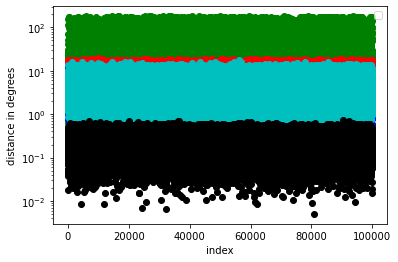

In [120]:
plt.semilogy()

#plt.axhline(y=quats_test_mean_err,color='g',label='quat')
#plt.axhline(y= test_mean_err_6D,color='r',label='6D')
#plt.axhline(y=ours_test_mean_err,color='b',label='A')
#plt.axhline(y=adj_mean_err,color='cyan',label='adjugate')
#plt.axhline(y=test_mean_err,color='k',label='RMSD soln')

plt.plot(quats_errors,'go')
plt.plot(errors_6D,'ro')
plt.plot(ours_errors,'bo')
plt.plot(adj_errors,'co')
plt.plot(errors,'ko')


plt.legend()
#plt.ylim(0,50)
plt.ylabel('distance in degrees')
plt.xlabel('index')
#plt.savefig('adjugate_errors_semilogy.png')

No handles with labels found to put in legend.


Text(0.5, 0, 'index')

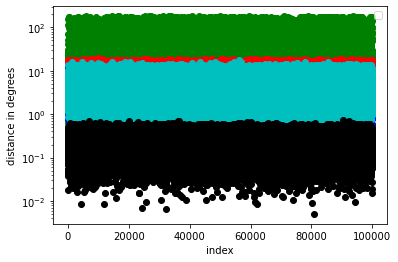

In [121]:
plt.semilogy()

#plt.axhline(y=quats_test_mean_err,color='g',label='quat')
#plt.axhline(y= test_mean_err_6D,color='r',label='6D')
#plt.axhline(y=ours_test_mean_err,color='b',label='A')
#plt.axhline(y=adj_mean_err,color='cyan',label='adjugate')
#plt.axhline(y=test_mean_err,color='k',label='RMSD soln')

plt.plot(quats_errors,'go')
plt.plot(errors_6D,'ro')
plt.plot(ours_errors,'bo')
plt.plot(adj_errors,'co')
plt.plot(errors,'ko')


plt.legend()
#plt.ylim(0,50)
plt.ylabel('distance in degrees')
plt.xlabel('index')
#plt.savefig('adjugate_errors_semilogy-res.png',dpi=300)

In [136]:
#adjugate
min(adj_errors), max(adj_errors)

(tensor(0.0902), tensor(17.5385))

In [138]:
mean(adj_errors), std(adj_errors)

(4.193534, 2.3399796)

### Now what does horn do?

In [122]:
#made from expanding trace of R(q) dot E
def M_from_E(E):
    M = np.zeros((4, 4))
    M[0,0] = E[0][0] + E[1][1] + E[2][2]
    M[0,1] = E[1][2] - E[2][1] 
    M[0,2] = E[2][0] - E[0][2] 
    M[0,3] = E[0][1] - E[1][0] 

    M[1,0] = E[1][2] - E[2][1] 
    M[1,1] = E[0][0] - E[1][1] - E[2][2]
    M[1,2] = E[0][1] + E[1][0] 
    M[1,3] = E[2][0] + E[0][2] 

    M[2,0] = E[2][0] - E[0][2] 
    M[2,1] = E[0][1] + E[1][0]
    M[2,2] = -E[0][0] + E[1][1] - E[2][2]
    M[2,3] = E[1][2] + E[2][1] 

    M[3,0] = E[0][1] - E[1][0] 
    M[3,1] = E[2][0] + E[0][2]
    M[3,2] = E[1][2] + E[2][1] 
    M[3,3] = -E[0][0] - E[1][1] + E[2][2]
    
    return M

In [123]:
def Horn_function(test_data):
    Horn_result = []

    for i in range(len(test_data.x)):
        #i=0
        X = test_data.x[i][0]
        Y = test_data.x[i][1]
        X_T = np.transpose(X)
        E = np.dot(X_T,Y)
        M = M_from_E(E)
        M_tensor = torch.Tensor(M)
        l = torch.symeig(M_tensor,eigenvectors=True)
        [q0,qx,qy,qz] = np.transpose(l.eigenvectors)[3].tolist()
        M_solution = [qx,qy,qz,q0]
        
        Horn_result.append(M_solution)
        
    return Horn_result

In [124]:
Horn_results = Horn_function(test_data)

In [125]:
Horn_results_Tensor = torch.Tensor(Horn_results)

In [126]:
num_test_batches = len(Horn_results)
Horn_errors = []
for k in range(num_test_batches):
    Horn_errors.append(quat_angle_diff(Horn_results_Tensor[k], test_q[k]))

In [127]:
#adjugate
min(Horn_errors), max(Horn_errors)

(tensor(0.0051), tensor(0.7244))

In [128]:
#RMSD
min(errors), max(errors)

(tensor(0.0051), tensor(0.7244))

In [130]:
mean(errors), std(errors)

(0.22575144, 0.09563155)